# What is the S-Learner?
The S-Learner (Single Learner) is a meta-learning approach used in causal inference to estimate the Conditional Average Treatment Effect (CATE). It uses a single machine learning model to predict outcomes for both treated and untreated groups.

In the credit limit setting problem, we use the S-Learner to estimate how a credit limit increase impacts customer spending, while considering risk (default) and churn (attrition).

# Step 1: Load Required Libraries and Generate Data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Set random seed for reproducibility
np.random.seed(42)

# Simulate a dataset for customers
n_samples = 5000

df = pd.DataFrame({
    'credit_score': np.random.randint(500, 850, n_samples),  # Credit score range
    'income': np.random.randint(30000, 150000, n_samples),  # Annual income
    'current_limit': np.random.randint(1000, 20000, n_samples),  # Current credit limit
    'spend': np.random.uniform(500, 10000, n_samples),  # Monthly spend
    'churn': np.random.choice([0, 1], size=n_samples, p=[0.9, 0.1]),  # Whether the customer churned
    'default': np.random.choice([0, 1], size=n_samples, p=[0.95, 0.05]),  # Whether the customer defaulted
    'increase_limit': np.random.choice([0, 1], size=n_samples, p=[0.5, 0.5])  # Whether limit was increased
})

# Create a new column for Target Variable: Additional Spend (Proxy for LTV)
df['additional_spend'] = df['spend'] * (1 + 0.2 * df['increase_limit'])  # 20% more spend if limit increased

# Show sample data
df.head()


Matplotlib is building the font cache; this may take a moment.


,credit_score,income,current_limit,spend,churn,default,increase_limit,additional_spend
0,602,99460,11874,9829.423916,0,0,1,11795.308700
1,848,87767,7163,1414.341666,0,0,0,1414.341666
2,770,58054,6264,6097.511373,0,1,1,7317.013647
3,606,105319,18615,6451.406625,0,0,1,7741.687950
4,571,132789,16890,5611.755657,0,0,0,5611.755657


In [13]:
# Select features
X = df[['credit_score', 'income', 'current_limit', 'spend','churn','default']]

# Define Treatment Variable (T) - Whether limit was increased
T = df['increase_limit']

# Define Target Variable (Y) - Additional Spend (Proxy for LTV)
Y = df['additional_spend']

# Split into train-test sets (80% train, 20% test)
X_train, X_test, T_train, T_test, Y_train, Y_test = train_test_split(X, T, Y, test_size=0.2, random_state=42)

In [14]:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
scaler = StandardScaler()

# Fit on training data and transform both train and test data
X_train_scaled = scaler.fit_transform(X_train)  # Learn mean & std from training data
X_test_scaled = scaler.transform(X_test)  # Apply same transformation to test data

# Step 1: Train the S-Learner Model
The S-Learner works by using a single machine learning model where the treatment variable (increase_limit) is added as a feature. The model learns how the increase in credit limit impacts additional spend.

- 📌 If using Gradient Boosting (or another tree-based model), we do not need standardization.
- 📌 If using Linear Regression or another distance-based model, we apply the scaled data.

In [15]:
# Train S-Learner Model
s_learner = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)
s_learner.fit(np.column_stack([X_train, T_train]), y_train)

# Concatenate treatment variable (increase_limit) as a feature
X_train_s = np.column_stack((X_train_scaled, T_train))
X_test_s = np.column_stack((X_test_scaled, T_test))

# Train the model
s_learner.fit(X_train_s, Y_train)

# Make predictions
Y_pred_train = s_learner.predict(X_train_s)
Y_pred_test = s_learner.predict(X_test_s)


# Step 2: Estimate Counterfactual Outcomes
To estimate the Conditional Average Treatment Effect (CATE) for each customer, we predict two outcomes:

- If the treatment was applied (increase_limit = 1)
- If the treatment was NOT applied (increase_limit = 0)



In [16]:
# Predict potential outcomes under both treatment conditions
X_test_T1 = np.column_stack((X_test_scaled, np.ones(len(X_test_scaled))))  # Limit increase = 1
X_test_T0 = np.column_stack((X_test_scaled, np.zeros(len(X_test_scaled)))) # No limit increase = 0

preds_T1 = s_learner.predict(X_test_T1)  # Predicted spend if limit was increased
preds_T0 = s_learner.predict(X_test_T0)  # Predicted spend if limit was NOT increased

# Compute CATE (difference between treatment and no-treatment predictions)
CATE = preds_T1 - preds_T0


# Step 3: Analyze & Visualize the Impact
Now that we have estimated CATE, we can analyze:

- How much additional spending is expected due to the credit limit increase
- Whether there is enough impact to justify limit increases for specific customers


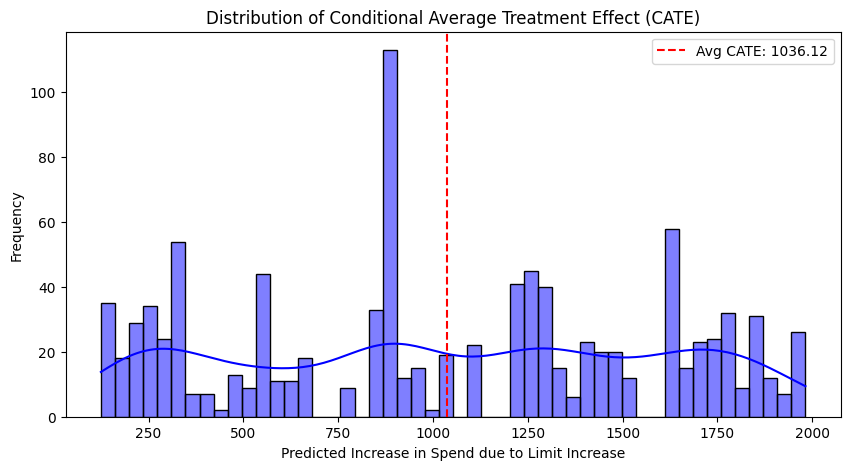

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,5))
sns.histplot(CATE, bins=50, kde=True, color='blue')

# Mark the average effect with a red dashed line
plt.axvline(x=CATE.mean(), color='red', linestyle='--', label=f'Avg CATE: {CATE.mean():.2f}')

plt.title("Distribution of Conditional Average Treatment Effect (CATE)")
plt.xlabel("Predicted Increase in Spend due to Limit Increase")
plt.ylabel("Frequency")
plt.legend()
plt.show()


# Step 4: Identify "Good Candidates" for Limit Increase
Now that we have an estimate of how much additional spending a customer will make due to a limit increase, we can select good candidates for a credit limit increase.

✅ Good Candidates:

- High predicted spend increase (CATE > threshold, e.g., $1000)
- Low risk (not likely to default or churn)


In [20]:
# Add predicted default probability and churn risk
df_test = df.iloc[X_test.index].copy()
df_test['predicted_spend_T1'] = preds_T1
df_test['predicted_spend_T0'] = preds_T0
df_test['CATE'] = CATE

# Define a "Good Candidate" for limit increase
# Criteria: If spending increases significantly & risk is low
df_test['good_candidate'] = (df_test['CATE'] > 1000) & (df_test['default'] == 0) & (df_test['churn'] == 0)

# Show top customers for limit increase
df_test[df_test['good_candidate']].head()



,credit_score,income,current_limit,spend,churn,default,increase_limit,additional_spend,predicted_spend_T1,predicted_spend_T0,CATE,good_candidate
1055,622,50827,1432,9142.323963,0,0,1,10970.788756,11035.853930,9245.388626,1790.465304,True
106,634,79422,10727,6161.304715,0,0,1,7393.565658,7376.183212,6134.704046,1241.479166,True
589,669,100469,10546,5761.393701,0,0,1,6913.672441,6915.427257,5693.998792,1221.428465,True
1600,757,126502,5888,6443.838216,0,0,0,6443.838216,7695.184038,6430.031337,1265.152701,True
915,849,37493,6192,9219.124132,0,0,1,11062.948958,11043.649553,9253.184248,1790.465304,True
